# 1. Knowledge Graphs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ramshreyas/Ontodidact/blob/main/YouTube/1_Knowledge_Graphs/notebooks/1_Knowledge_Graphs.ipynb)

---

### Setup & Imports

In [1]:
%pip install llama-index networkx matplotlib pyvis llama-index-graph-stores-neo4j llama-index-embeddings-huggingface

Note: you may need to restart the kernel to use updated packages.


In [2]:
# General imports
import os
from pprint import pprint
import dotenv
dotenv.load_dotenv()

# Async
import nest_asyncio
nest_asyncio.apply()

---

### A toy knowledge graph

A knowledge graphs represents **knowledge** in the form of *entities* and the **relationships** between them. Let's use the family tree of House Lannister from Game of Thrones as an example:

In [3]:
# Import network visualitzation libraries
import networkx as nx
import matplotlib.pyplot as plt

Create a directed graph

In [4]:
G = nx.DiGraph()

Add nodes for each member of the Lannister family - these are our **entities**

In [5]:
characters = ["Tywin", "Joanna", "Cersei", "Jaime", "Tyrion", "Joffrey", "Myrcella", "Tommen"]
G.add_nodes_from(characters)

Now let's add their **relationships**. 

Here we are only considering parent-child relationships, so this would essentially represent a family tree.

In [6]:
# Adding relationships
relationships = [
    ("Tywin", "Cersei"), ("Joanna", "Cersei"),
    ("Tywin", "Jaime"), ("Joanna", "Jaime"),
    ("Tywin", "Tyrion"), ("Joanna", "Tyrion"),
    ("Cersei", "Joffrey"), ("Jaime", "Joffrey"),
    ("Cersei", "Myrcella"), ("Jaime", "Myrcella"),
    ("Cersei", "Tommen"), ("Jaime", "Tommen")
]
G.add_edges_from(relationships)

Visualize the House Lannister

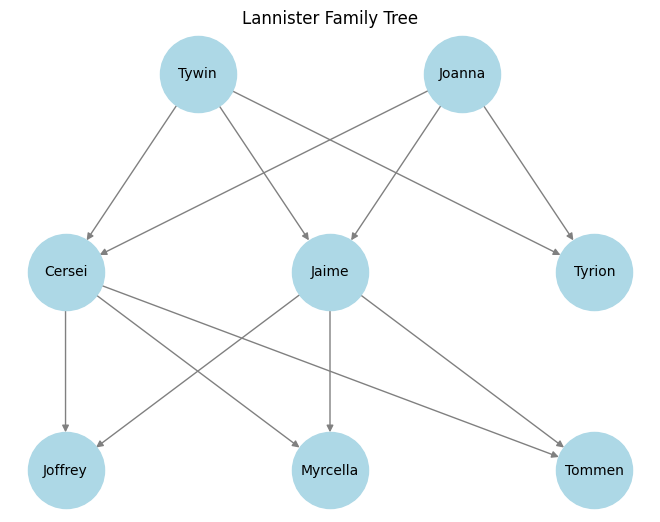

In [7]:
# Adding relationships
relationships = [
    ("Tywin", "Cersei"), ("Joanna", "Cersei"),
    ("Tywin", "Jaime"), ("Joanna", "Jaime"),
    ("Tywin", "Tyrion"), ("Joanna", "Tyrion"),
    ("Cersei", "Joffrey"), ("Jaime", "Joffrey"),
    ("Cersei", "Myrcella"), ("Jaime", "Myrcella"),
    ("Cersei", "Tommen"), ("Jaime", "Tommen")
]
G.add_edges_from(relationships)

# Manually set positions for a family tree layout
pos = {
    "Tywin": (0.5, 1),
    "Joanna": (1.5, 1),
    "Cersei": (0, 0.5),
    "Jaime": (1, 0.5),
    "Tyrion": (2, 0.5),
    "Joffrey": (0, 0),
    "Myrcella": (1, 0),
    "Tommen": (2, 0)
}

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10, font_color="black")

plt.title('Lannister Family Tree')
plt.axis('off')  # Turn off the axis
plt.show()

So this family tree represents a particular piece of knowledge. 

It contains *explicit* knowledge - that Jaime (illegitimately) fathered Joffrey.

It also contains *implicit* knowledge - that Cersei and Jaime are siblings, which is not directly represented as a relationship between the entities - more on this later.

In this visualization, entities are represented by nodes or *verteces*, and relationships are represented by the lines or *edges* connecting them.

This is a simple knowledge graph.

---

### LLMs can extract knowledge graphs directly from text

Now I'm sure you'll agree that was a bit tedious. Listing our relationships explicitly and building knowledge graphs can get overwhelming very quickly. 

The good news is that LLMs and LlamaIndex can help! This is where things get really interesting. 

Let's load a text description of house Lannister, which we will use as a source to create a knowledge graph without OpenAI and LlamaIndex.

In [8]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader("./data/").load_data()

In [9]:
pprint(documents[0].get_text())

('The House of Lannister stands as a pillar of power and influence in '
 'Westeros, with Tywin Lannister at its head. \n'
 'Tywin, the patriarch of the Lannister family, was married to Joanna '
 'Lannister. Both hailing from the same noble \n'
 "house, their union reinforced the family's lineage and status. Joanna "
 'Lannister bore three children to Tywin: \n'
 'Cersei Lannister, Jaime Lannister, and Tyrion Lannister.\n'
 '\n'
 'Tywin Lannister is the father of Cersei Lannister, Jaime Lannister, and '
 'Tyrion Lannister. Cersei, the eldest of \n'
 "Tywin's children, has established herself as a cunning and ambitious leader. "
 'Her brother, Jaime Lannister, known \n'
 'as the Kingslayer, shares not only a twin bond with Cersei but also a '
 'controversially close relationship. The \n'
 'youngest sibling, Tyrion, often finds himself in conflict with Tywin, '
 'primarily due to the circumstances surrounding \n'
 'his birth, which tragically resulted in the death of Joanna Lannister.\n'


Construct the knowledge graph index for the loaded documents using PropertyGraphIndex

In [10]:
from typing import Literal
from llama_index.llms.openai import OpenAI
from llama_index.core.indices.property_graph import SchemaLLMPathExtractor

# best practice to use upper-case
entities = Literal["PERSON"]
relations = Literal["CHILD_OF", 'PARENT_OF', "SIBLING_OF", "SPOUSE_OF"]

# define which entities can have which relations
validation_schema = {
    "PERSON": ["CHILD_OF", "PARENT_OF", "SIBLING_OF", "SPOUSE_OF"],
}

kg_extractor = SchemaLLMPathExtractor(
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.3),
    possible_entities=entities,
    possible_relations=relations,
    kg_validation_schema=validation_schema,
    # if false, allows for values outside of the schema
    # useful for using the schema as a suggestion
    strict=True,
)

TODO

In [11]:
from llama_index.graph_stores.neo4j import Neo4jPGStore

graph_store = Neo4jPGStore(
    username="neo4j",
    password=os.getenv("NEO4J_PASSWORD"),
    url="bolt://localhost:7687",
)
vec_store = None

TODO

In [12]:
from llama_index.core import PropertyGraphIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

index = PropertyGraphIndex.from_documents(
    documents,
    kg_extractors=[kg_extractor],
    embed_model=HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5"),
    property_graph_store=graph_store,
    vector_store=vec_store,
    show_progress=True,
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/home/ramshreyas/Documents/Ontodidact/.conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings: 100%|██████████| 3/3 [00:00<00:00, 38.95it/s]


---

### Querying the knowledge graph

---

### Viewing the knowledge graph with Neo4j (is awesome)